<a href="https://colab.research.google.com/github/nihil21/cnn-deblur/blob/master/cnn-deblur/cnn-deblur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cnn-deblur

This project aims at developing a Deep Neural Network able to deblur images, as part of the **Deep Learning** cours of the **Master in Artificial Intelligence** (*Alma Mater Studiorum*).  
This DNN should be able to correct both gaussian and motion blur, by training on Cifar10 and REDS datasets.

#### Authors:
 - Mattia Orlandi
 - Giacomo Pinardi

## Premises
Mount Google Drive to save checkpoints.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Prepare callback function to save weights to Drive.

In [2]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

metric = input("Metric ['accuracy'/'ssim_metric']: ")
filepath='/content/drive/My Drive/cnn-deblur/ep:{epoch:03d}-val_' + metric + ':{val_' + metric + ':.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_{:s}'.format(metric), verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Metric ['accuracy'/'ssim_metric']: ssim_metric


Enable GPU to speed up the processing; in case the notebook is not connected to a GPU runtime, it falls back to TPU.  
If that fails too, an exception is raised.

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import os

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  GPU = False
  print('GPU device not found, trying to connect to TPU runtime...')
  
  if 'COLAB_TPU_ADDR' not in os.environ:
    print('ERROR: Not connected to a TPU runtime, aborting...')
  else:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    tf.config.experimental_connect_to_host('grpc://' + os.environ['COLAB_TPU_ADDR'])
    print ('TPU address is', tpu_address)
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)

else:
  GPU = True
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Connect to GitHub, download the required Python modules from the repository.

In [4]:
from getpass import getpass
import urllib

# Change working directory
os.chdir('/content')

# Remove all directory
! rm -r 'cnn-deblur'

# Read credentials to GitHub
user = input('User name: ')
password = getpass('Password: ')
password = urllib.parse.quote(password)

cmd_string = 'git clone https://{0:s}:{1:s}@github.com/nihil21/cnn-deblur.git'.format(user, password)

os.system(cmd_string)
cmd_string, password = "", ""

User name: nihil21
Password: ··········


Change working directory.

In [0]:
# Move inside cloned repository
os.chdir(os.path.join('cnn-deblur', 'cnn-deblur'))

Import the Python modules and other relevant libraries.

In [6]:
from model.conv_net import ConvNet
from model.toy_resnet import ToyResNet
from model.resnet_64_dense import ResNet64Dense
from model.resnet_64 import ResNet64
from model.resnet_128 import ResNet128
from model.u_net import UNet
from utils.image_preprocessing import *
from keras.utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


## 1. Cifar10
Preprocess the Cifar10 dataset by blurring images with a random standard deviation and reserve samples for validation.

In [7]:
# Preprocess Cifar10 dataset
(trainX, trainY), (valX, valY), (testX, testY) = preproc_cifar10(normalize=True)

print('Training set size: {0:d}'.format(trainX.shape[0]))
print('Validation set size: {0:d}'.format(valX.shape[0]))
print('Test set size: {0:d}'.format(testX.shape[0]))

Time elapsed: 4.83 s
Training set size: 37500
Validation set size: 12500
Test set size: 10000


Create a ConvNet object suited for the Cifar10 dataset and plot its structure.

Architecture type ['toy'/'64dense'/'64'/'128'/'unet']: unet
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_0 (Conv2D)                (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 32, 32, 16)   2320        conv1_0[0][0]                    
__________________________________________________________________________________________________
pool2 (MaxPooling2D)            (None, 16, 16, 16)   0           conv1_1[0][0]                    
__________________________________

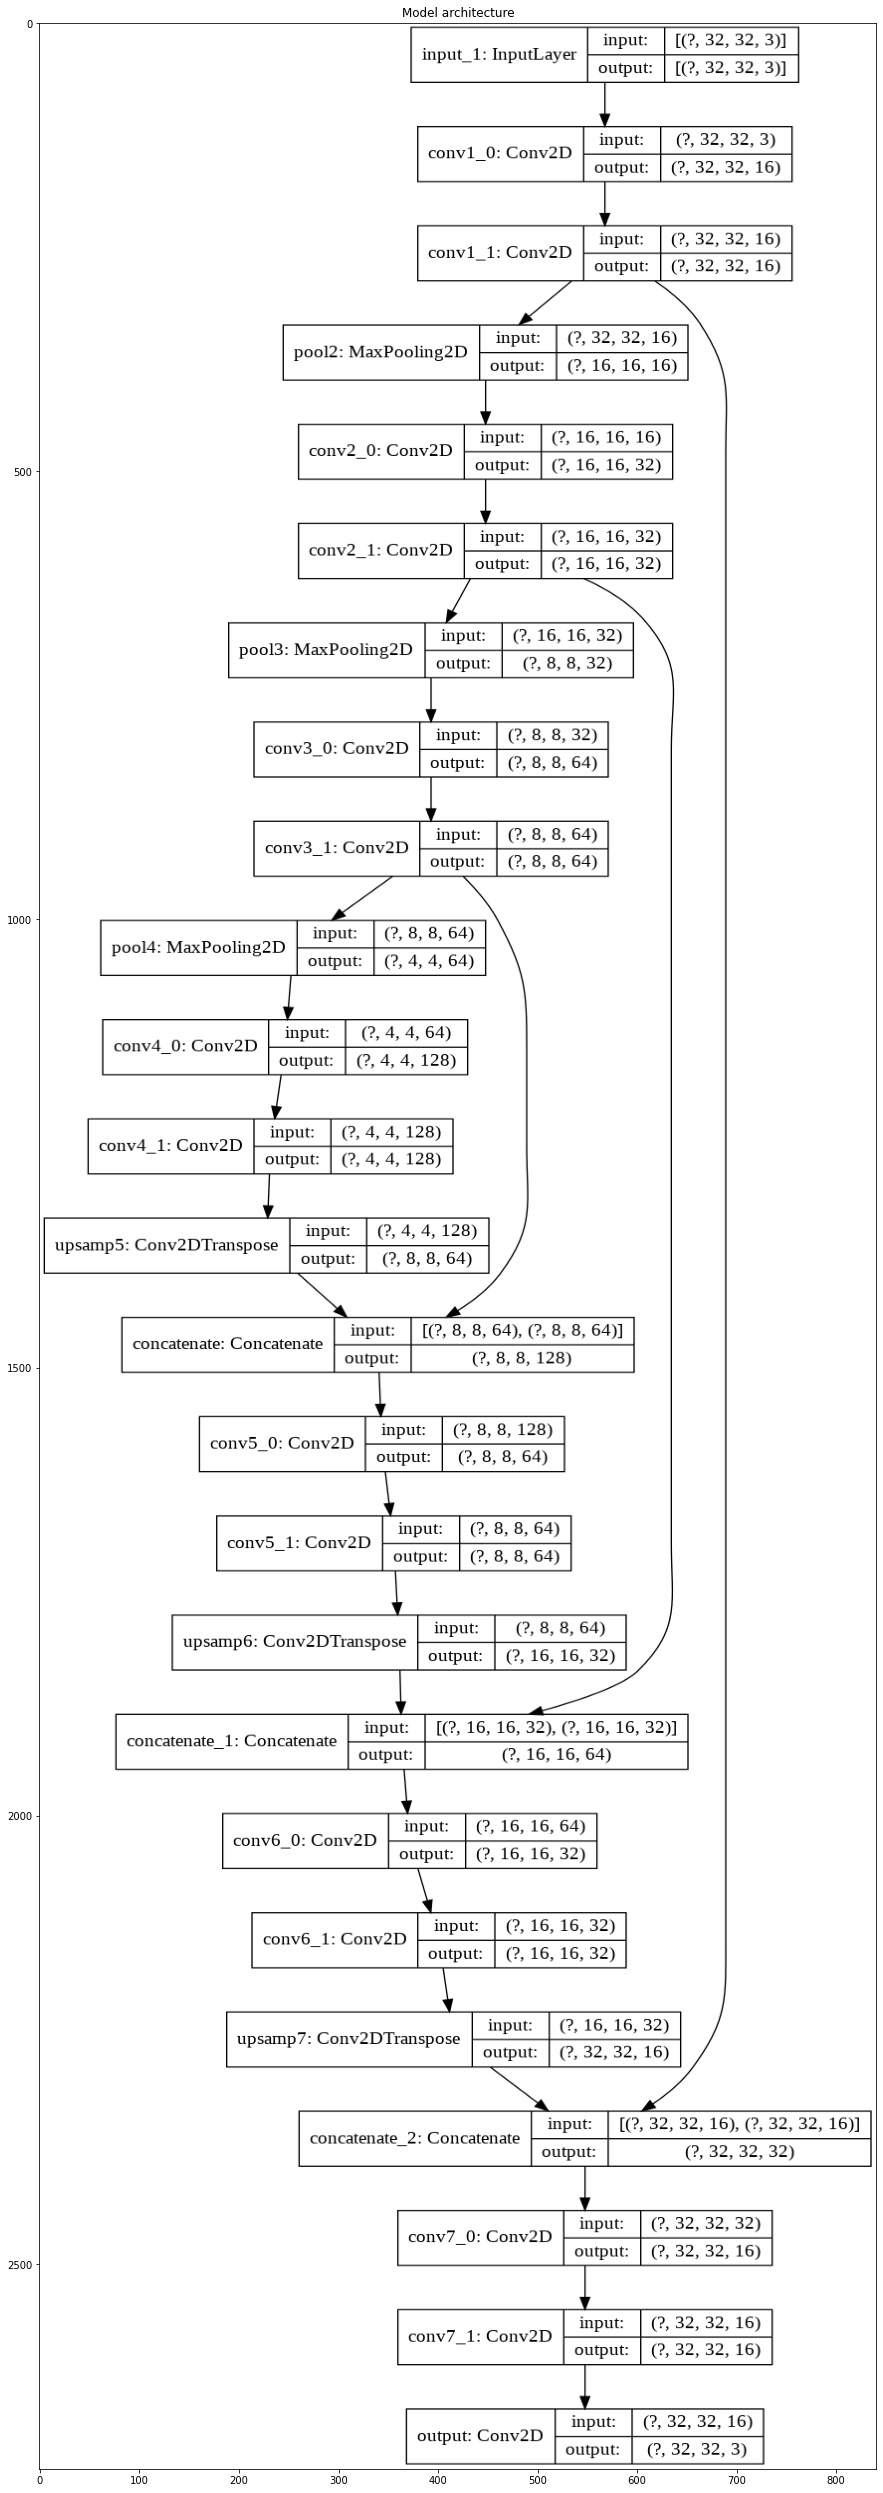

In [8]:
# Create dictionary of possible architectures
arch_dict = dict({
    'toy': ToyResNet,
    '64dense': ResNet64Dense,
    '64': ResNet64,
    '128': ResNet128,
    'unet': UNet
})
arch_type = input("Architecture type ['toy'/'64dense'/'64'/'128'/'unet']: ")

# Create ConvNet and plot model
if GPU:
  conv_net = arch_dict[arch_type](input_shape=(32, 32, 3))
  conv_net.compile(loss='mse', metric=metric)

else:
  tf.compat.v1.disable_eager_execution()
  with strategy.scope():
    conv_net = arch_dict[arch_type](input_shape=(32, 32, 3))
    conv_net.compile(loss='mse', metric=metric)
  

print(conv_net.summary())
path_to_model = os.path.join('..', 'res', 'model.png')
conv_net.plot_model(path_to_model)
fig, ax = plt.subplots(figsize=(15, 45))
ax.set_title('Model architecture')
plt.imshow(mpimg.imread(path_to_model), aspect='auto');

Load weights from previous run.

In [0]:
import glob

folder = input('Folder: ')
init_ep = int(input('Initial epoch: '))

weights = glob.glob('/content/drive/My Drive/cnn-deblur/{0:s}/ep:{1:03d}-val_acc:*.hdf5'.format(folder, init_ep))
conv_net.model.load_weights(weights[0])

Train model following *train-validation-test* paradigm.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ep = 50
bs = 4
seed = 42
steps_train = len(trainX) // bs
steps_val = len(valX) // bs

# Data augmentation
trainX_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
trainY_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
trainX_data = trainX_datagen.flow(trainX, batch_size=bs, seed=seed)
trainY_data = trainY_datagen.flow(trainY, batch_size=bs, seed=seed)
train_data = (pair for pair in zip(trainX_data, trainY_data))

if 'init_ep' not in locals():
  init_ep = 0
print('Initial epoch: {0:d}'.format(init_ep))

hist = conv_net.fit(train_data,
                    epochs=ep,
                    steps_per_epoch=steps_train,
                    validation_data=(valX, valY),
                    validation_steps=steps_val,
                    initial_epoch=init_ep,
                    callbacks=callbacks_list);

Initial epoch: 0
Epoch 1/50
9375/9375 [==============================] - 97s 10ms/step - loss: 0.0073 - ssim_metric: 0.7494 - val_loss: 0.0044 - val_ssim_metric: 0.8068
Epoch 2/50
9375/9375 [==============================] - 95s 10ms/step - loss: 0.0037 - ssim_metric: 0.8311 - val_loss: 0.0034 - val_ssim_metric: 0.8451
Epoch 3/50
9375/9375 [==============================] - 95s 10ms/step - loss: 0.0032 - ssim_metric: 0.8531 - val_loss: 0.0032 - val_ssim_metric: 0.8573
Epoch 4/50
9375/9375 [==============================] - 96s 10ms/step - loss: 0.0029 - ssim_metric: 0.8642 - val_loss: 0.0028 - val_ssim_metric: 0.8678
Epoch 5/50
9375/9375 [==============================] - 95s 10ms/step - loss: 0.0028 - ssim_metric: 0.8705 - val_loss: 0.0028 - val_ssim_metric: 0.8723
Epoch 6/50
9375/9375 [==============================] - 95s 10ms/step - loss: 0.0027 - ssim_metric: 0.8751 - val_loss: 0.0026 - val_ssim_metric: 0.8757
Epoch 7/50
9375/9375 [==============================] - 97s 10ms/step -

Evaluate the model on the test set.

In [10]:
results = conv_net.model.evaluate(testX, testY, batch_size=bs)
print('Test loss, Test {:s}:'.format(metric), results)

2500/2500 [==============================] - 9s 4ms/step - loss: 0.0020 - ssim_metric: 0.9044
Test loss, Test ssim_metric: [0.0019587953574955463, 0.9043664336204529]


Plot graph representing the loss and accuracy trends over epochs.

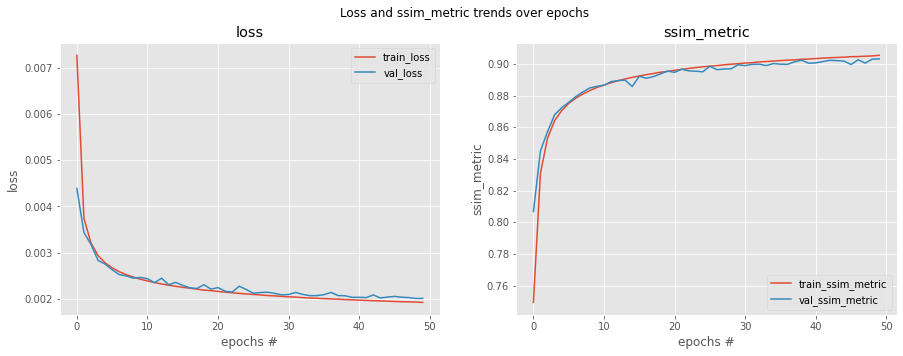

In [11]:
n = np.arange(0, ep - init_ep)
plt.style.use('ggplot')
fig, (ax_l, ax_a) = plt.subplots(ncols=2, figsize=(15, 5))
fig.suptitle('Loss and {:s} trends over epochs'.format(metric))
# Loss
ax_l.plot(n, hist.history['loss'], label='train_loss')
ax_l.plot(n, hist.history['val_loss'], label='val_loss')
ax_l.set_title('loss')
ax_l.set(xlabel='epochs #', ylabel='loss')
ax_l.legend();
# Accuracy
ax_a.plot(n, hist.history[metric], label='train_{:s}'.format(metric))
ax_a.plot(n, hist.history['val_{:s}'.format(metric)], label='val_{:s}'.format(metric))
ax_a.set_title(metric)
ax_a.set(xlabel='epochs #', ylabel=metric)
ax_a.legend();

Generate predictions on new data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


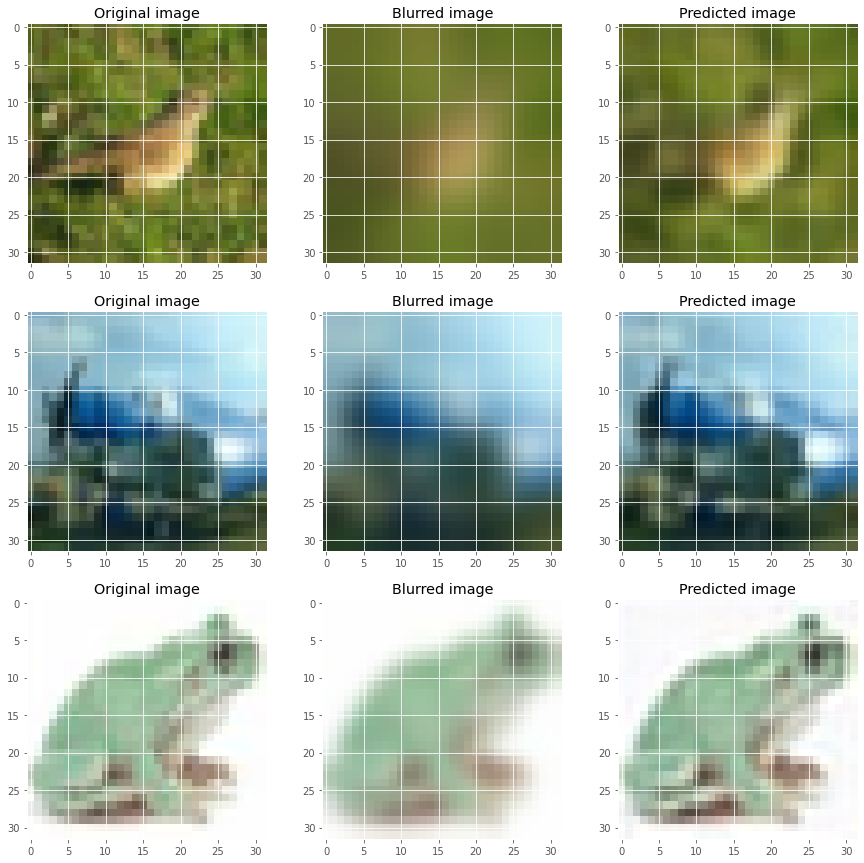

In [12]:
idx = np.random.randint(low=0, high=len(testX), size=3)
blurred = testX[idx]
original = testY[idx]

predicted = conv_net.predict(testX[idx])

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i in range(3):
  axes[i, 0].set_title('Original image')
  axes[i, 0].imshow(original[i]);
  axes[i, 1].set_title('Blurred image')
  axes[i, 1].imshow(blurred[i]);
  axes[i, 2].set_title('Predicted image')
  axes[i, 2].imshow(predicted[i]);